# Data Preprocessing

In [879]:
# import statements
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
from scipy.stats import skew
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.special import boxcox1p
from scipy import stats
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.pipeline import make_pipeline
from sklearn import ensemble
from sklearn import cluster
from sklearn import pipeline
from sklearn import decomposition
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

### Output settings

In [880]:
pd.set_option("display.max_rows", 3000)
pd.set_option("display.max_columns", 300)

In [881]:
sns.set_palette('Set2')

In [882]:
sns.set_palette('Paired')

In [883]:
sns.set_context('paper')

## Import data

In [884]:
# import dataset train.csv
dtrain="data/train.csv"
dtest="data/test.csv"

In [885]:
# read data into pandas
train_data=pd.read_csv(dtrain, index_col=0)
test_data=pd.read_csv(dtest, index_col=0)

In [886]:
# put data into dataframe
df_train = pd.DataFrame(train_data)
print(df_train.shape)

(1460, 80)


In [887]:
df_test= pd.DataFrame(test_data)
print(df_test.shape)

(1459, 79)


### Remove outliers

In [888]:
df_train = df_train[df_train["GrLivArea"] <= 4500]

In [889]:
df_test = df_test[df_test["GrLivArea"] <= 4500]

### Remove SalePrice for data preprocessing

In [890]:
# pop SalePrice column from train
df_y = df_train.pop('SalePrice')

### Combine Test and Train data for preprocessing

In [891]:
df_all = df_train.append(df_test)

## Data Cleaning

### Convert nominal data to object

In [892]:
# features to convert to object for encoding
int_to_ord = ['MSSubClass', 'MoSold']

for col in int_to_ord:
    df_all[col] = df_all[col].astype('object')

### Fill in Missing Values

#### Fill area and count features with zero

In [893]:
# features to fill na with zero
fill_zero = ['MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'TotalBsmtSF', 'GarageCars',
             'GarageArea', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageYrBlt']

# fill na with zero 
for col in fill_zero:
    df_all[col].fillna(0, inplace=True)

#### Fill continuous features with neighborhood mean

In [894]:
# featurs to fill na with neighborhood mean
fill_mean = ['LotFrontage']

for col in fill_mean:
    df_all[col] = df_all.groupby("Neighborhood").transform(lambda x: x.fillna(x.mean()))

#### Fill category features with mode

In [895]:
fill_mode = ['Electrical', 'MSZoning', 'Functional', 'Utilities', 'SaleType', 'Exterior1st', 'Exterior2nd']

for col in fill_mode:
    new_val = df_all[col].mode().values[0]
    df_all[col].fillna(new_val, inplace=True)

#### Fill missing features with 0 for encoding

In [896]:
fill = ['PoolQC', 'FireplaceQu', 'GarageQual','GarageCond', 'BsmtCond', 'BsmtQual', 'KitchenQual',
            'MiscFeature', 'Alley', 'Fence', 'GarageType', 'GarageFinish', 'BsmtExposure', 'BsmtFinType2',
            'BsmtFinType1', 'MasVnrType']

for col in fill:
    df_all[col].fillna(0, inplace=True)

#### Confirm all missing values have been filled

In [897]:
df_all.count().sort_values().head()

MSSubClass      2916
FireplaceQu     2916
Fireplaces      2916
Functional      2916
TotRmsAbvGrd    2916
dtype: int64

## Feature Engineering

### Super size features

In [898]:
# Total Square Footage
df_all['TotalSqft'] = (df_all['BsmtFinSF1'] + df_all['BsmtFinSF2'] + 
                       df_all['1stFlrSF'] + df_all['2ndFlrSF'])

# Total Baths
df_all['TotalBath'] = (df_all['FullBath'] + (0.5*df_all['HalfBath']) +
                       df_all['BsmtFullBath'] + (0.5*df_all['BsmtHalfBath']))

# Total Outdoor Space
df_all['TotalOutdoor'] = (df_all['OpenPorchSF'] + df_all['3SsnPorch'] + 
                          df_all['EnclosedPorch'] + df_all['ScreenPorch'] + df_all['WoodDeckSF'])

### Normalize Skewed Numerical Features

In [899]:
# find all numeric cols
numeric = []
for col in df_all.columns:
    if df_all[col].dtype != object: 
        numeric.append(col)
        
# calculate skew of each col
skew = df_all[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew})

# push cols with skew > 0.5 to array
transform_skew = []
standardize = []
for index, row in skews.iterrows():
    if(row['skew'] > .5):
        transform_skew.append(index)
    else:
        standardize.append(index)

In [900]:
for col in transform_skew:
    df_all[col] = boxcox1p(df_all[col], stats.boxcox_normmax(df_all[col]+1))

### Combine similar categories with low count

In [901]:
#LotShape: 0: regular, 1: irregular
df_all['LotShape'] = df_all['LotShape'].apply(lambda x: 0 if x == "Reg" else 1)

#LotConfig: combine FL2+FL3
df_all['LotConfig'].replace({'FR3':'FR2_3', 'FR2':'FR2_3'}, inplace=True)

#LandSlope: combine mod/sev
df_all['LandSlope'].replace({'Sev':'Mod_Sev', 'Mod':'Mod_Sev'}, inplace=True)

#RoofMtl: 0: shingle, 1: not shingle
df_all['RoofMatl'] = df_all['RoofMatl'].apply(lambda x: 0 if x == "CompShg" else 1)

#Heating: 0: GasA, 1: notGasA
df_all['Heating'] = df_all['Heating'].apply(lambda x: 0 if x == "GasA" else 1)

#Electrical: Sbrk, not
df_all['Electrical'] = df_all['Electrical'].apply(lambda x: 0 if x == "SBrkr" else 1)

### Bin Neighborhoods

In [902]:
# Top 25% by mean/median sale price
high = ['Veenker', 'Somerst', 'Timber', 'StoneBr', 'NoRidge', 'NridgHt']

# Bottom 25% by mean/median sale price
low = ['MeadowV', 'IDOTRR', 'BrDale', 'OldTown', 'Edwards', 'BrkSide']

df_all['Neighborhood_H'] = df_all['Neighborhood'].apply(lambda x: 1 if x in high else 0)
df_all['Neighborhood_L'] = df_all['Neighborhood'].apply(lambda x: 1 if x in low else 0)
df_all['Neighborhood_M'] = df_all['Neighborhood'].apply(lambda x: 1 if x not in low and x not in high else 0)

### Bin YearBuilt

In [903]:
bins = ['pre-40s','40s-60s','60s-80s','80s-00s','post-2000']

df_all['TimePeriod'] = pd.cut(df_all['YearBuilt'],[1800,1940,1960,1980,2000,2012],labels=bins).astype('object')

### Combine and one hot encode non-normal Conditions

In [904]:
df_all['Condition1'] = df_all['Condition1'].apply(lambda x: None if x == "Norm" else x)
df_all['Condition2'] = df_all['Condition2'].apply(lambda x: None if x == "Norm" else x)

df_all = pd.concat([df_all,pd.get_dummies(df_all['Condition1'], prefix='Condition')],axis=1)
df_all.drop(['Condition1'],axis=1, inplace=True)

for index, row in df_all.iterrows():
    if row['Condition2'] != 'Norm':
        if row['Condition2'] == 'Feedr':          
            df_all.at[index, 'Condition_Feedr'] = 1
        
        if row['Condition2'] == 'Artery':
            df_all.at[index, 'Condition_Artery'] = 1
        
        if row['Condition2'] == 'RRNn':
            df_all.at[index, 'Condition_RRNn'] = 1
        
        if row['Condition2'] == 'RRAn':
            df_all.at[index, 'Condition_RRAn'] = 1
        
        if row['Condition2'] == 'PosN':
            df_all.at[index, 'Condition_PosN'] = 1
        
        if row['Condition2'] == 'PosA':
            df_all.at[index, 'Condition_PosA'] = 1
        
        if row['Condition2'] == 'RRNe':
            df_all.at[index, 'Condition_RRNe'] = 1
        
        if row['Condition2'] == 'RRAe':
            df_all.at[index, 'Condition_RRAe'] = 1

df_all.drop(['Condition2'],axis=1, inplace=True)

### Drop highly correlated features

In [905]:
#GarageArea, 0.9 corr with GarageCars
df_all.drop(columns=['GarageArea'], inplace=True)

#GarageYrBlt, 0.8 corr with YrBuilt
df_all.drop(columns=['GarageYrBlt'], inplace=True)

#Exterior2nd, highly corr with Exterior1st
df_all.drop(columns=['Exterior2nd'], inplace=True)

#MiscFeature, value described by MiscValue
df_all.drop(columns=['MiscFeature'], inplace=True)

### Create Binary Features

In [906]:
binary = ['BsmtFinSF1', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch','3SsnPorch', 'ScreenPorch', 'PoolArea']

for col in binary:
    new_name = 'Has_' + col
    df_all[new_name] = df_all[col].apply(lambda x: 1 if x > 0 else 0)

### Newly remodeled

In [907]:
df_all['NewlyRemodeled'] = 0
for index, row in df_all.iterrows():
    if int(row['YrSold']) - int(row['YearRemodAdd']) <= 2:
        df_all.at[index, 'NewlyRemodeled'] = 1        

### Encode Ordinal Features

### One Hot Encode Nominal Features

In [908]:
ordinal = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual',
           'GarageCond', 'PoolQC']
           
mask = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA': 0, 'None': 0, np.nan: 0}
    
for col in ordinal:
    df_all[col].replace(mask, inplace=True)
    
df_all['BsmtExposure'].replace({'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}, inplace=True)
df_all['BsmtFinType1'].replace({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, np.nan:0}, inplace=True)
df_all['BsmtFinType2'].replace({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, np.nan:0}, inplace=True)
df_all['GarageFinish'].replace({'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}, inplace=True)
df_all['Fence'].replace({'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, 'None':0}, inplace=True)

In [909]:
nominal = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities', 'LotConfig', 
           'LandSlope', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 
           'MasVnrType', 'Foundation', 'CentralAir', 'Functional', 'GarageType', 'PavedDrive', 'MoSold',
           'YrSold', 'SaleType', 'SaleCondition', 'TimePeriod']

# one hot encoding all data
for col in nominal:
    df_all = pd.concat([df_all,pd.get_dummies(df_all[col], prefix=col)],axis=1)
    df_all.drop([col],axis=1, inplace=True)

In [910]:
df_all.shape

(2916, 236)

In [911]:
df_all.count().sort_values().head()

LotFrontage          2916
RoofStyle_Gambrel    2916
RoofStyle_Hip        2916
RoofStyle_Mansard    2916
RoofStyle_Shed       2916
dtype: int64

## Finalize Data Transformations

### Split data back into Train/Test

In [912]:
df_train = df_all.loc[0:1460]
df_test = df_all.loc[1461:2919]

In [913]:
print(df_train.shape)
print(df_test.shape)

(1458, 236)
(1458, 236)


### Distribution of Sale Price

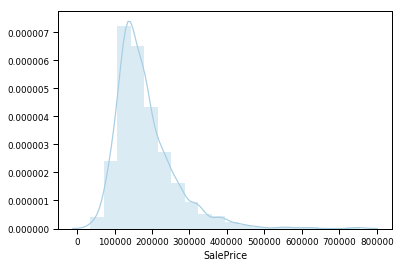

In [914]:
sns.distplot(df_y, bins=20)

The data is right skew, but taking ln(1+x) of the data will normalize it.

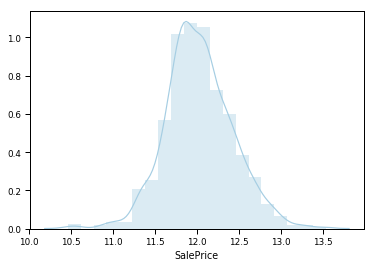

In [915]:
sns.distplot(np.log1p(df_y), bins=20)

In [916]:
df_y = np.log1p(df_y)

### Split labeled data for train/test

In [917]:
X_train, X_test, y_train, y_test = train_test_split(df_train, df_y, test_size=0.2, random_state=24)

### Summary Functions

In [918]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=32)

def model_score_train(model):
    error = (cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kfolds))
    rmse = np.sqrt(-error)
    return(rmse.mean())

def model_score_test(model):
    error = (cross_val_score(model, X_test, y_test, scoring='neg_mean_squared_error', cv=kfolds))
    rmse = np.sqrt(-error)
    return(rmse.mean())

In [919]:
def model_summary(model):
    
    # Print R-sq
    print('R-sq:', "\t\t\t%.4f" % model.score(X_train, y_train))
    
    # Predict Y-hat with train data
    y_hat = model.predict(X_train)
    
    # Set up plot area for pred/actual
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(15,6))
    fig.suptitle('Predicted vs. Actual', fontsize=16)
    ax1.set_title('Train')
    ax2.set_title('Test')
    
    # Plot Y-hat vs. Y-actual train data
    sns.scatterplot(x=np.expm1(y_hat), y=np.expm1(y_train), ax=ax1)
    
    # Predict Y-hat with test data
    y_hatV = model.predict(X_test)

    # Plot Y-hat vs. Y-actual test data
    sns.scatterplot(x=np.expm1(y_hatV), y=np.expm1(y_test), ax=ax2)
    
    # Calculate RMSE for train and test
    print('RMSE (Train):', "\t\t%.4f" % np.sqrt(mean_squared_error(y_train, y_hat)))
    print('RMSE (Test):', "\t\t%.4f" % np.sqrt(mean_squared_error(y_test, y_hatV)))
    
    # Calculate score with cross validation
    print('CV_RMSE (Train):', "\t%.4f" % model_score_train(model))
    print('CV_RMSE (Test):', "\t%.4f" % model_score_test(model))
    
    # Set up plot area for residuals
    fig2, (ax3, ax4) = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(15,6))
    fig2.suptitle('Residuals', fontsize=16)
    ax1.set_title('Train')
    ax2.set_title('Test')
    
    # Plot residuals train data
    residuals_train = np.expm1(y_train) - np.expm1(y_hat)
    sns.scatterplot(x=np.expm1(y_train), y=residuals_train, ax=ax3) 
    
    # Plot residuals test data
    residuals_test = np.expm1(y_test) - np.expm1(y_hatV)
    sns.scatterplot(x=np.expm1(y_test), y=residuals_test, ax=ax4)

# Regression

## Baseline Regression (Ordinary Least Squares)

Fits a linear model with to minimize the residual sum of squares between the observed responses in the dataset, and the responses predicted by the linear approximation.

In [920]:
reg = linear_model.LinearRegression().fit(X_train, y_train)

R-sq: 			0.9480
RMSE (Train): 		0.0913
RMSE (Test): 		0.1059
CV_RMSE (Train): 	0.1225
CV_RMSE (Test): 	23162492.1187


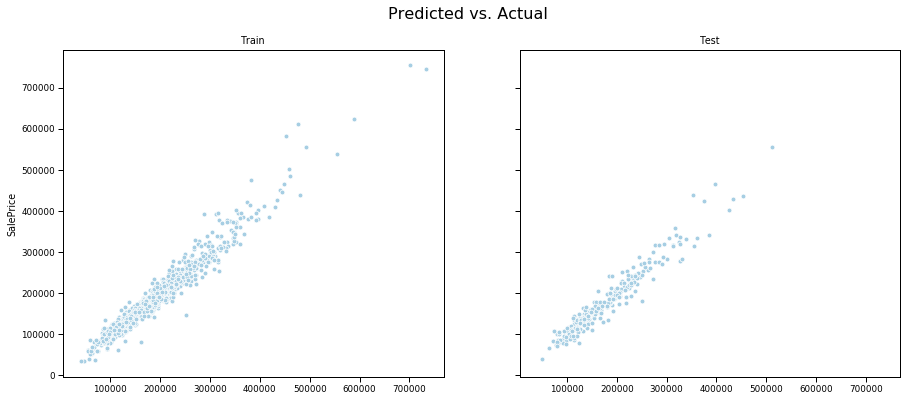

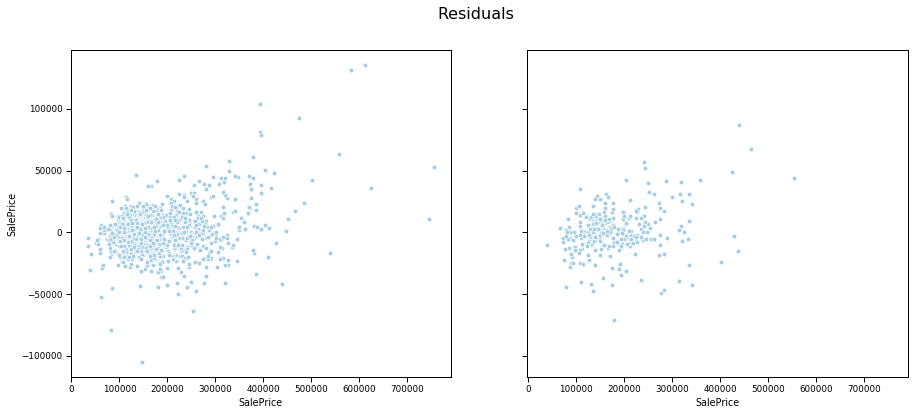

In [921]:
model_summary(reg)

## Lasso Regression (Optimize alpha through Cross Validation)

With so many features, it is unlikely that all are important. Lasso Regression uses coefficient descent based on an alpha to filter out coefficients that are not accretive to the model.  

In [922]:
clf = linear_model.LassoCV(eps=1e-5, cv=5, random_state=0).fit(X_train, y_train)

In [923]:
clf.alpha_

0.0010558986174662125

R-sq: 			0.9311
RMSE (Train): 		0.1052
RMSE (Test): 		0.0981
CV_RMSE (Train): 	0.1137
CV_RMSE (Test): 	0.1116


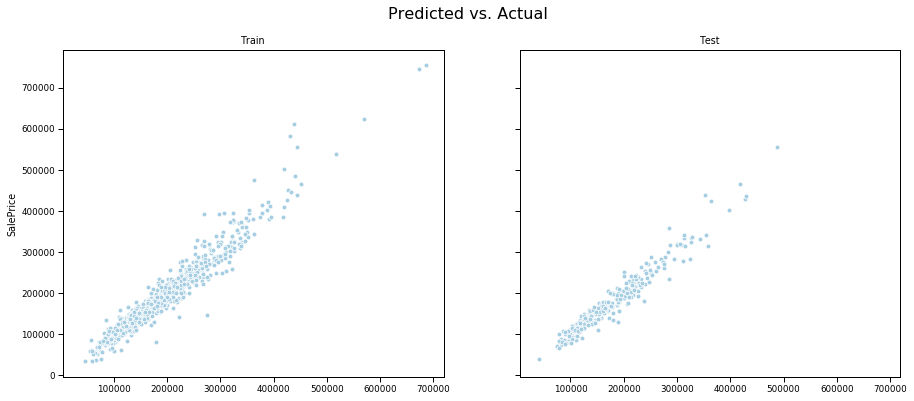

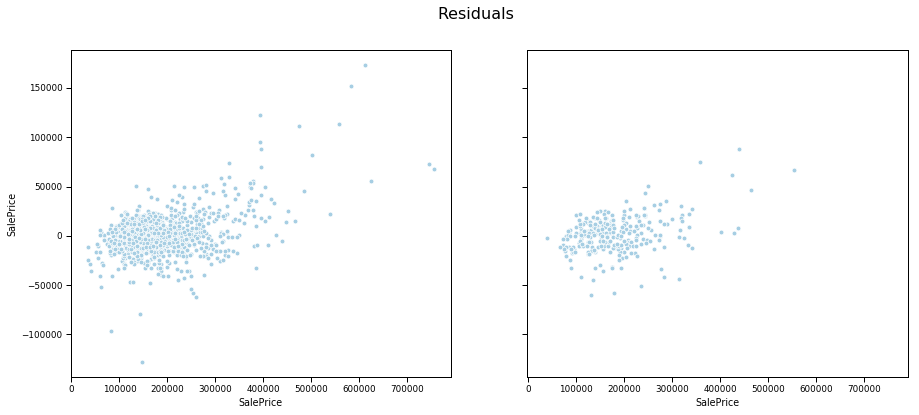

In [924]:
model_summary(clf)

## Ridge Regression

In [925]:
ridge = linear_model.RidgeCV(alphas=[15, 15.5, 15.75, 15.8, 16, 16.5, 17], cv=3).fit(X_train, y_train)   

In [926]:
ridge.alpha_

15.75

R-sq: 			0.9391
RMSE (Train): 		0.0989
RMSE (Test): 		0.0979
CV_RMSE (Train): 	0.1130
CV_RMSE (Test): 	0.1065


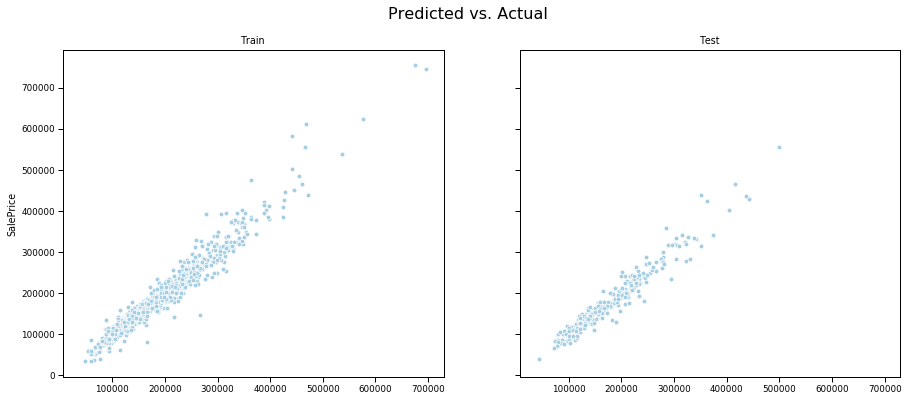

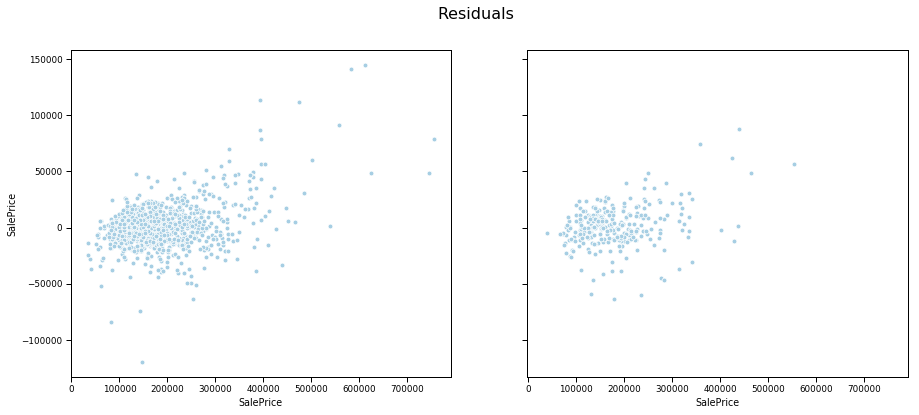

In [927]:
model_summary(ridge)

## ElasticNet

In [928]:
en = linear_model.ElasticNetCV(eps=1e-5, cv=5, random_state=0).fit(X_train, y_train)

In [929]:
en.alpha_

0.0021117972349324254

R-sq: 			0.9304
RMSE (Train): 		0.1057
RMSE (Test): 		0.0982
CV_RMSE (Train): 	0.1139
CV_RMSE (Test): 	0.1113


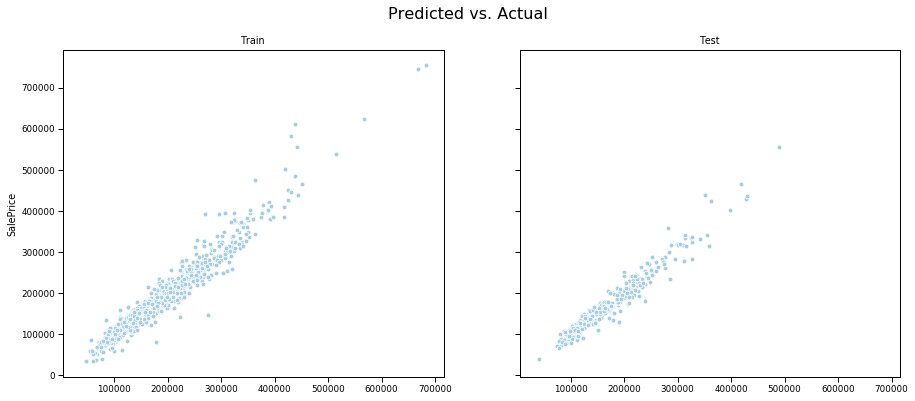

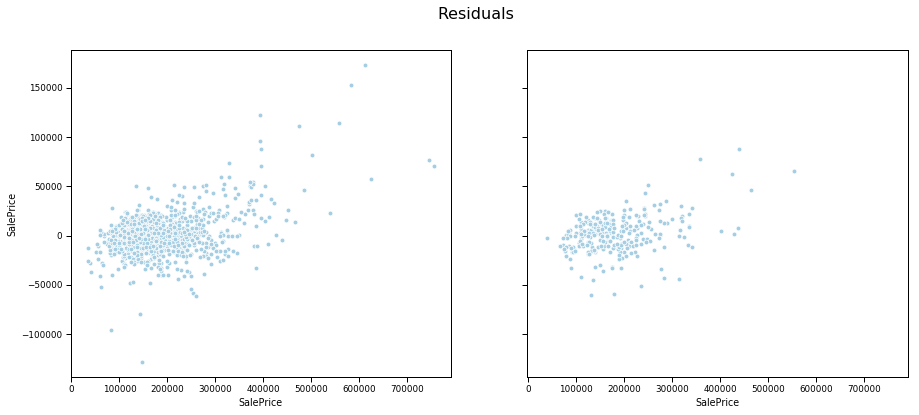

In [930]:
model_summary(en)

## Bayesian Ridge

In [931]:
br = linear_model.BayesianRidge().fit(X_train, y_train)

In [932]:
br.score(X_train, y_train)

0.9397167560461219

R-sq: 			0.9397
RMSE (Train): 		0.0984
RMSE (Test): 		0.0980
CV_RMSE (Train): 	0.1129
CV_RMSE (Test): 	0.1066


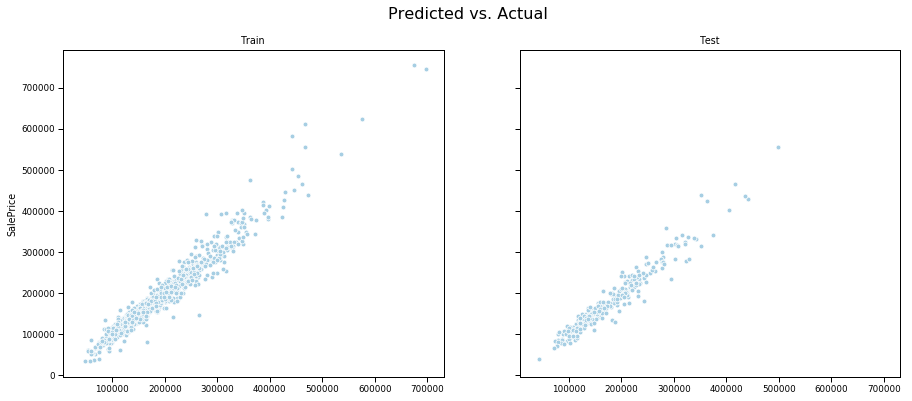

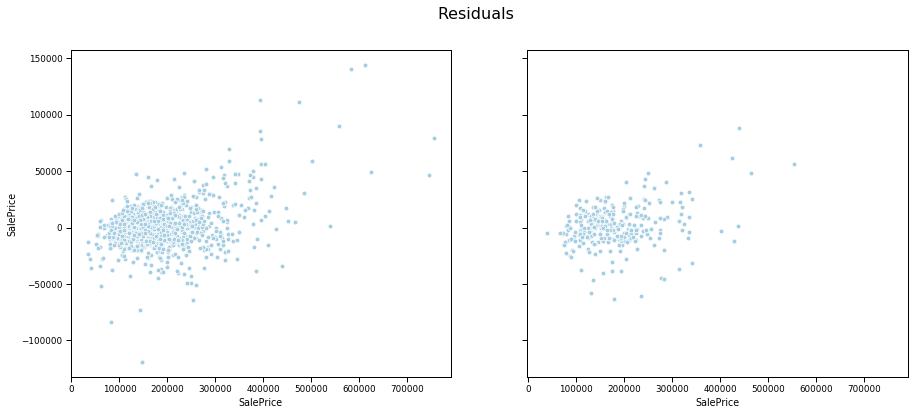

In [933]:
model_summary(br)

## SVM

In [934]:
sv = svm.SVR(gamma='auto').fit(X_train, y_train)

In [935]:
sv.score(X_train, y_train)

0.9383317351287005

R-sq: 			0.9383
RMSE (Train): 		0.0995
RMSE (Test): 		0.3744
CV_RMSE (Train): 	0.3872
CV_RMSE (Test): 	0.3911


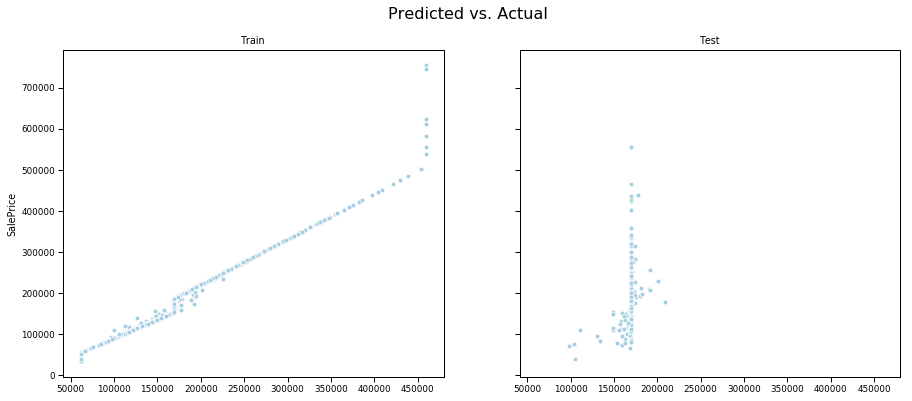

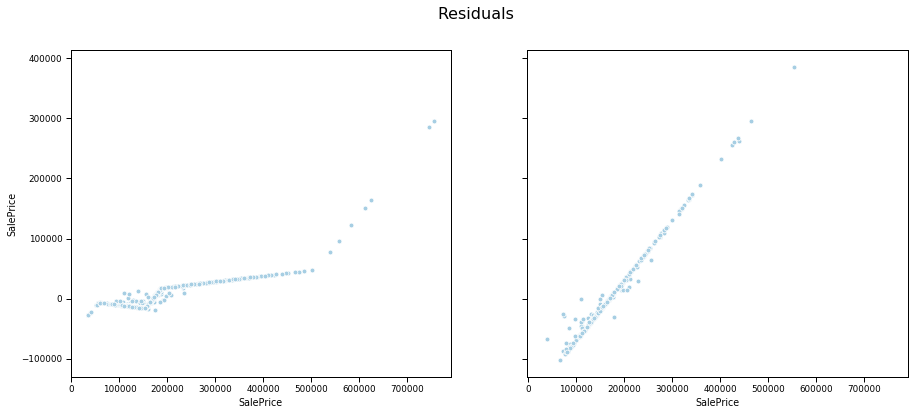

In [936]:
model_summary(sv)

## Decision Tree

In [937]:
dt = DecisionTreeRegressor(max_depth=8).fit(X_train, y_train)   

R-sq: 			0.9563
RMSE (Train): 		0.0838
RMSE (Test): 		0.1940
CV_RMSE (Train): 	0.2084
CV_RMSE (Test): 	0.2182


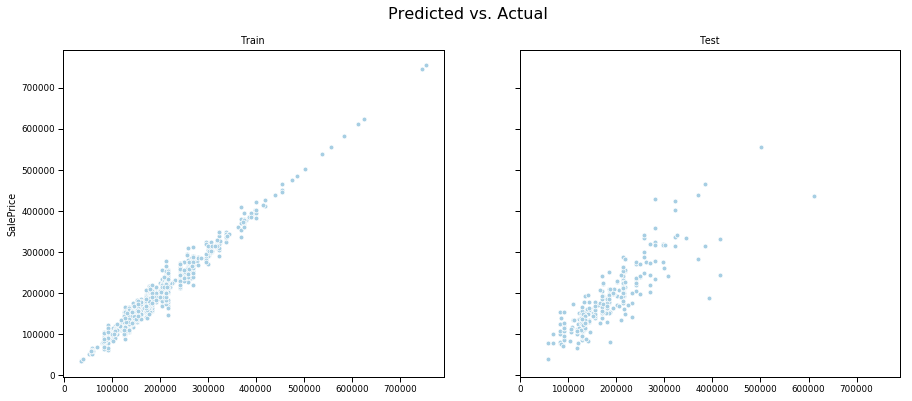

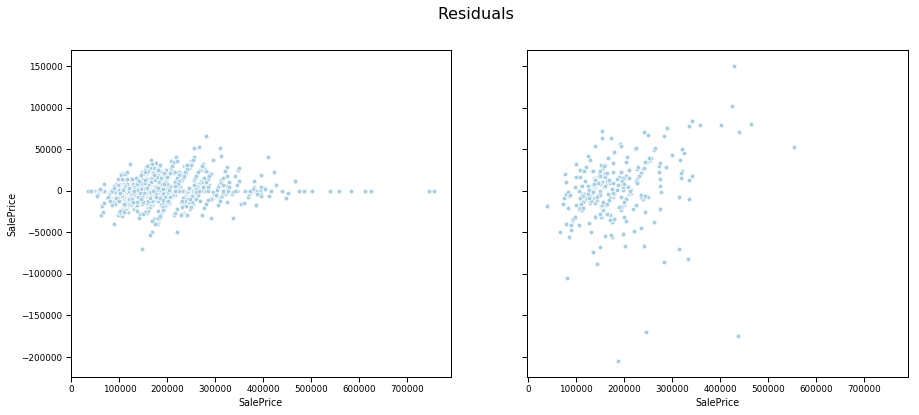

In [938]:
model_summary(dt)

## LassoLARS

In [939]:
from warnings import filterwarnings
filterwarnings('ignore')
lassolars = linear_model.LassoLarsCV(fit_intercept=False, cv=5).fit(X_train, y_train)

R-sq: 			0.9328
RMSE (Train): 		0.1038
RMSE (Test): 		0.0977
CV_RMSE (Train): 	0.1125
CV_RMSE (Test): 	0.1098


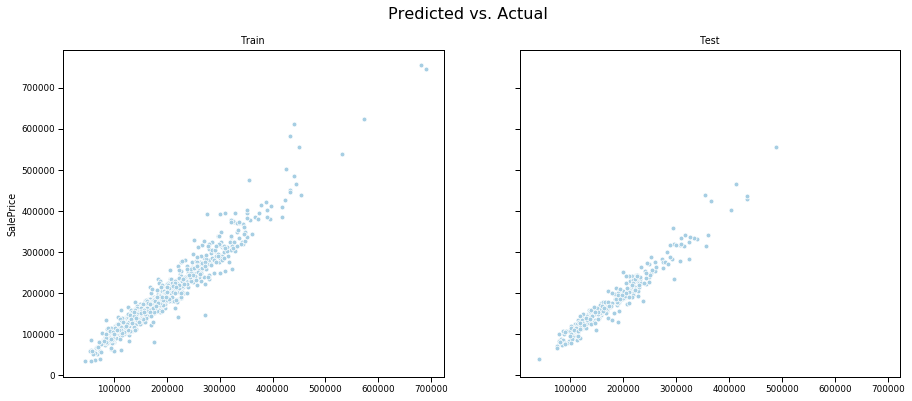

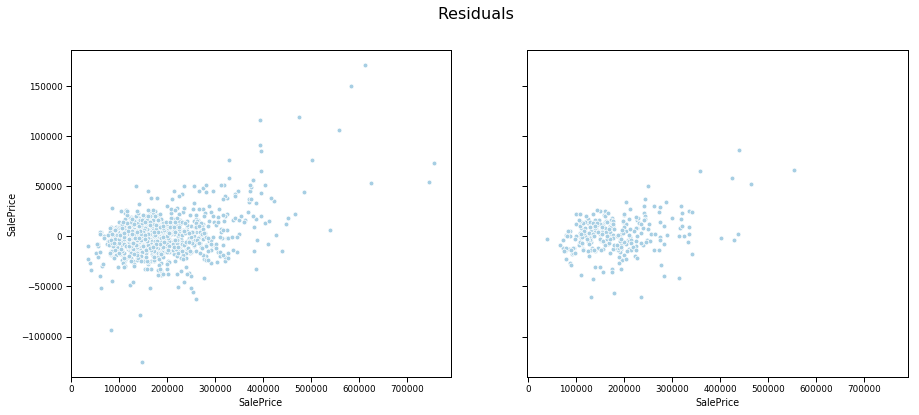

In [940]:
model_summary(lassolars)

# Ensemble Regressors

## Gradient Boost

In [955]:
params = {'n_estimators': 2000, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gbr = ensemble.GradientBoostingRegressor(**params).fit(X_train, y_train)

R-sq: 			0.9905
RMSE (Train): 		0.0391
RMSE (Test): 		0.1060
CV_RMSE (Train): 	0.1270
CV_RMSE (Test): 	0.1343


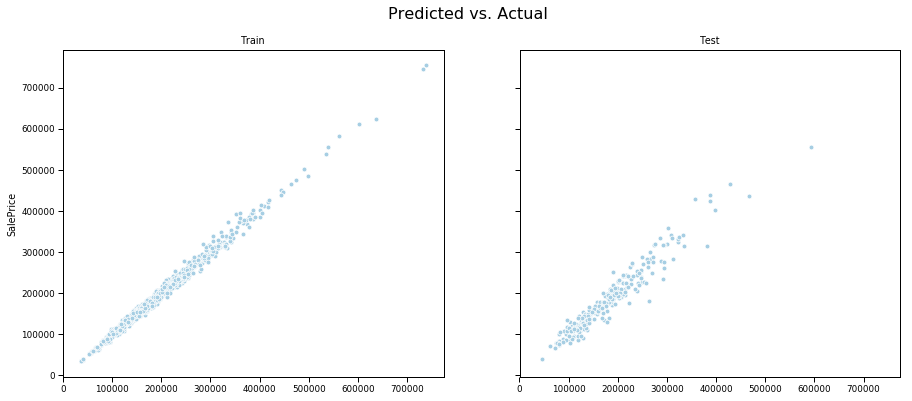

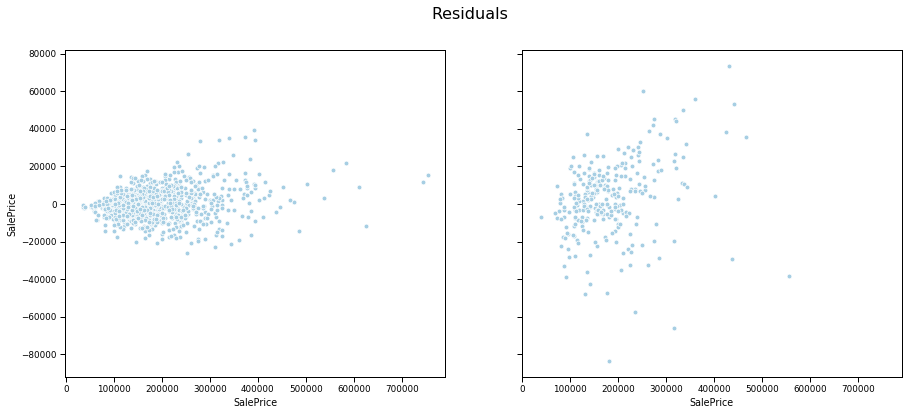

In [942]:
model_summary(gbr)

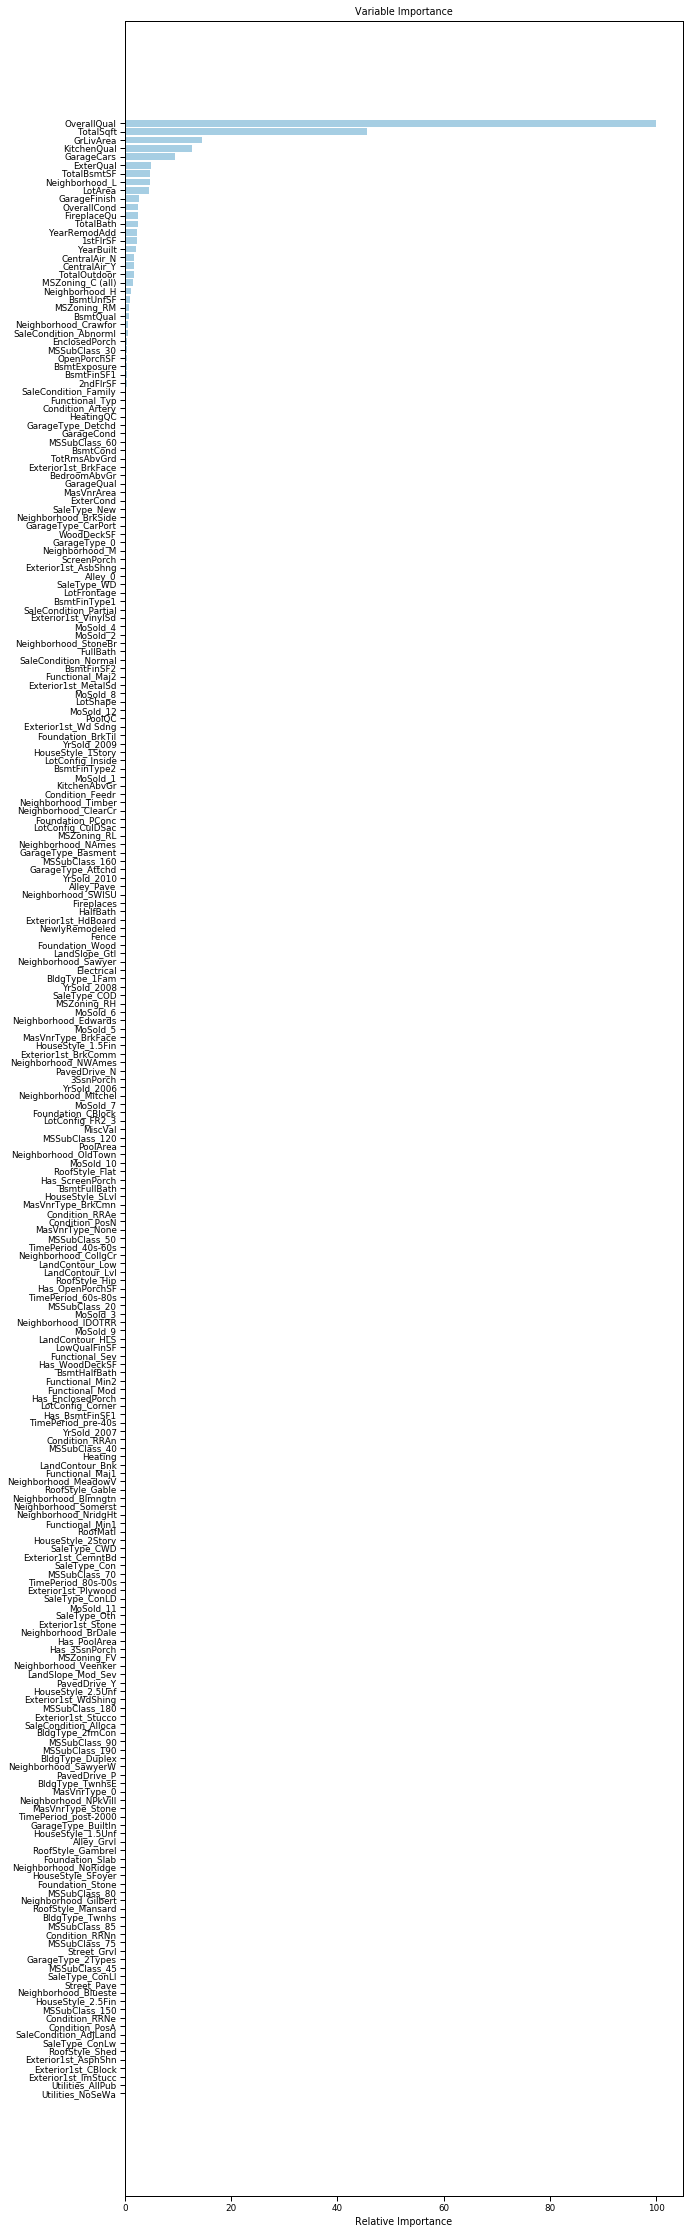

In [943]:
# Plot feature importance
feature_importance = gbr.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
plt.figure(figsize=(10, 40))
plt.barh(pos, feature_importance[sorted_idx])
plt.yticks(pos, df_all.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## ADABoost

In [962]:
ada = ensemble.AdaBoostRegressor(base_estimator=lassolars, n_estimators=1000, learning_rate=.10, loss='linear', random_state=None).fit(X_train, y_train)

In [963]:
ada.score(X_train, y_train)

0.9230591327486128

In [965]:
bag = BaggingRegressor(base_estimator=lassolars).fit(X_train, y_train)

In [966]:
bag.score(X_train, y_train)

0.9399402407077696

# Clustering

In [1021]:
kmeans = cluster.KMeans(n_clusters=2, random_state=0).fit(df_train[['OverallQual', 'Neighborhood_L']])

In [1022]:
kmeans.score(df_train[['OverallQual', 'Neighborhood_L']])

-1135.9948067283565

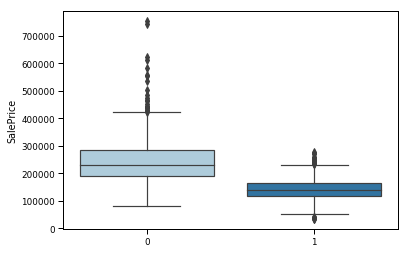

In [1023]:
sns.boxplot(kmeans.labels_, np.expm1(df_y))

In [1024]:
df_train_c = df_train.assign(cluster=kmeans.labels_)

In [1025]:
df_train_c = df_train_c.join(df_y)

In [1026]:
df_train_low = df_train_c.loc[df_train_c['cluster'] == 0]

In [1027]:
df_train_high = df_train_c.loc[df_train_c['cluster'] == 1]

In [1028]:
df_y_low = df_train_low.pop('SalePrice')
df_y_high = df_train_high.pop('SalePrice')

In [1029]:
df_train_high = df_train_high.drop(columns=['cluster'])

In [1030]:
df_train_low = df_train_low.drop(columns=['cluster'])

## Split Data: LOW

In [1031]:
X_train, X_test, y_train, y_test = train_test_split(df_train_low, df_y_low, test_size=0.2, random_state=24)

## Ridge

In [1032]:
ridge_low = linear_model.RidgeCV(alphas=[8, 9, 10, 11, 11.5, 12, 12.25, 12.5, 13, 14, 15, 20], cv=3).fit(X_train, y_train)   

In [1033]:
ridge_low.alpha_

12.0

R-sq: 			0.9262
RMSE (Train): 		0.0840
RMSE (Test): 		0.0928
CV_RMSE (Train): 	0.1100
CV_RMSE (Test): 	0.1135


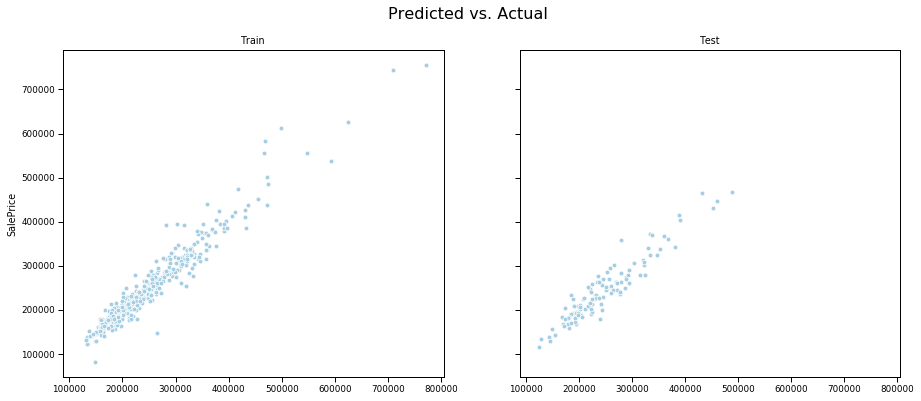

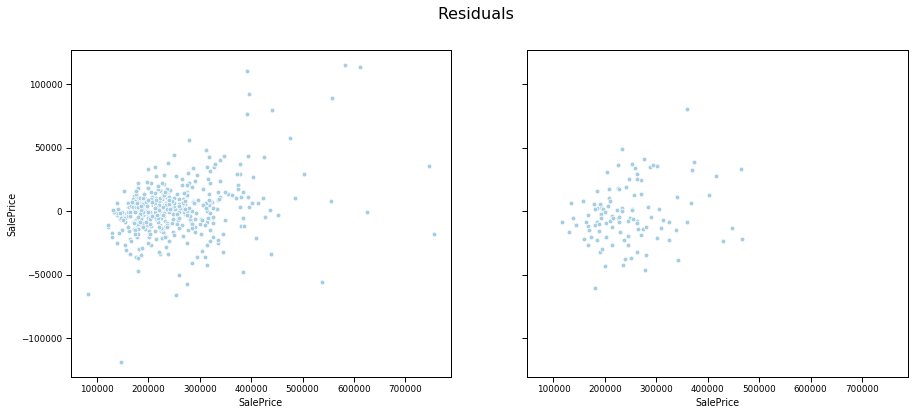

In [1034]:
model_summary(ridge_low)

## LassoLARS

In [1035]:
lassolars_low = linear_model.LassoLarsCV(fit_intercept=False, cv=5).fit(X_train, y_train)

R-sq: 			0.9252
RMSE (Train): 		0.0846
RMSE (Test): 		0.0955
CV_RMSE (Train): 	0.1104
CV_RMSE (Test): 	0.1169


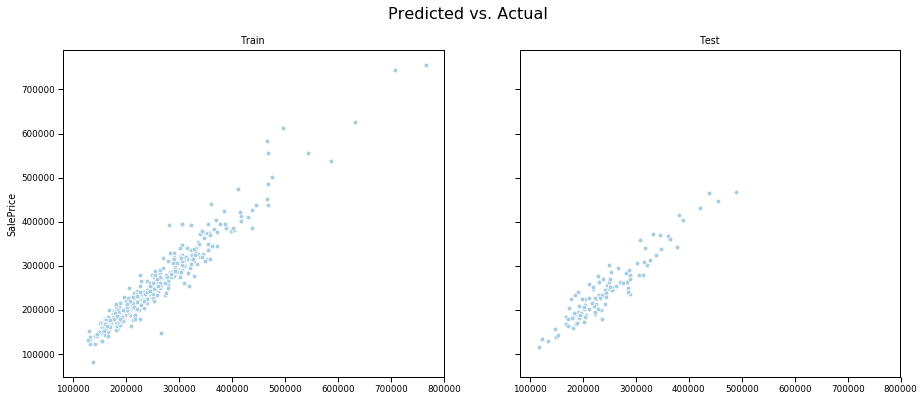

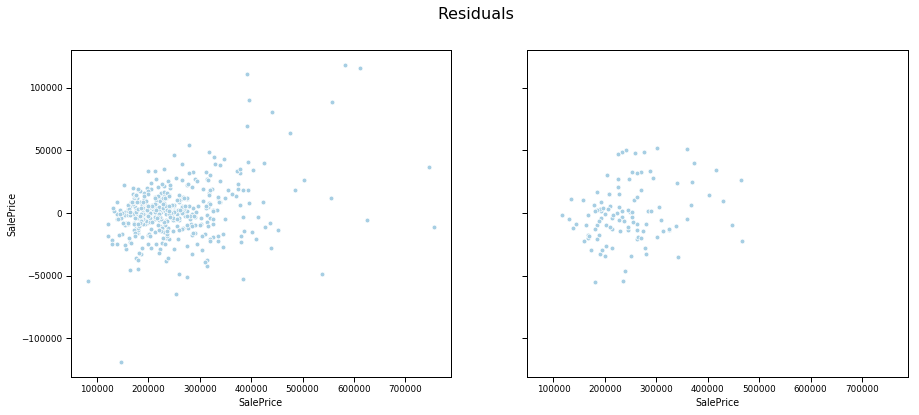

In [1036]:
model_summary(lassolars_low)

## Bayesian Ridge

In [1037]:
br_low = linear_model.BayesianRidge().fit(X_train, y_train)

R-sq: 			0.9228
RMSE (Train): 		0.0859
RMSE (Test): 		0.0929
CV_RMSE (Train): 	0.1102
CV_RMSE (Test): 	0.1142


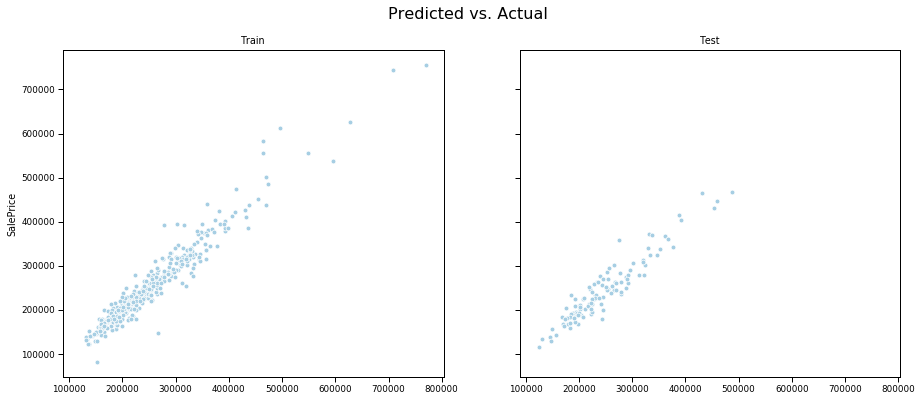

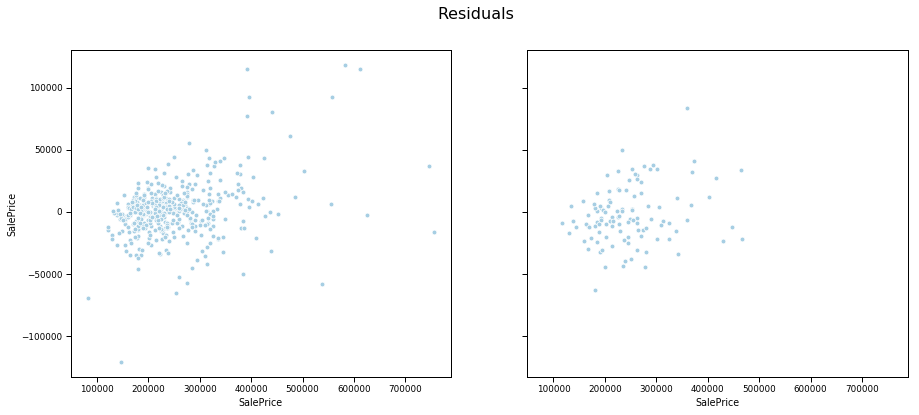

In [1038]:
model_summary(br_low)

### Prediction based on Ridge for cluster: Low

In [1053]:
y_hat_low = ridge_low.predict(df_train_low)

## Split Data: HIGH

In [1039]:
X_train, X_test, y_train, y_test = train_test_split(df_train_high, df_y_high, test_size=0.2, random_state=24)

## Ridge

In [1045]:
ridge_high = linear_model.RidgeCV(alphas=[10, 12, 25, 25.5, 26, 27], cv=5).fit(X_train, y_train)   

In [1046]:
ridge_high.alpha_

12.0

R-sq: 			0.8907
RMSE (Train): 		0.0929
RMSE (Test): 		0.1224
CV_RMSE (Train): 	0.1185
CV_RMSE (Test): 	0.1320


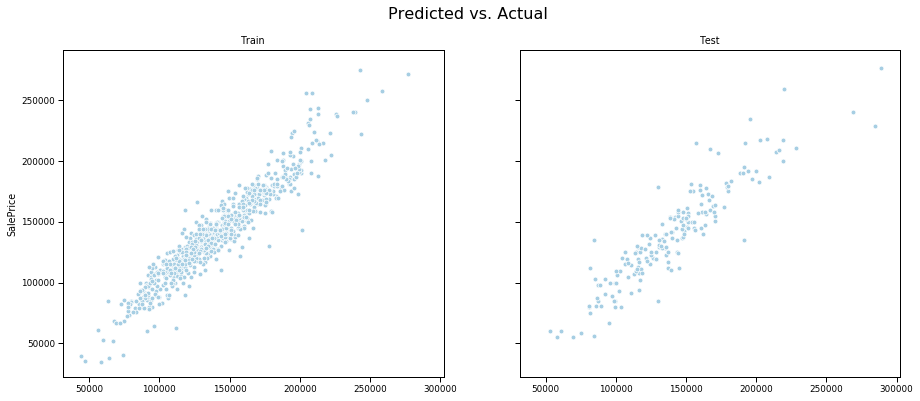

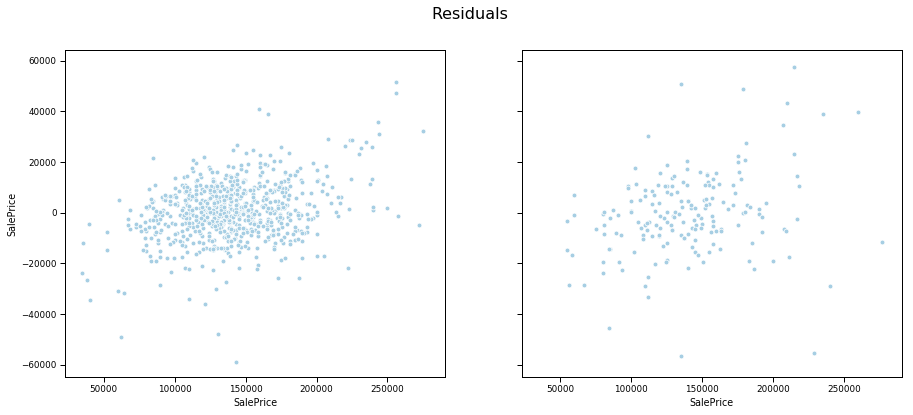

In [1047]:
model_summary(ridge_high)

## LassoLARS

In [1048]:
lassolars_high = linear_model.LassoLarsCV(fit_intercept=False, cv=5).fit(X_train, y_train)

R-sq: 			0.8583
RMSE (Train): 		0.1058
RMSE (Test): 		0.1213
CV_RMSE (Train): 	0.1178
CV_RMSE (Test): 	0.1377


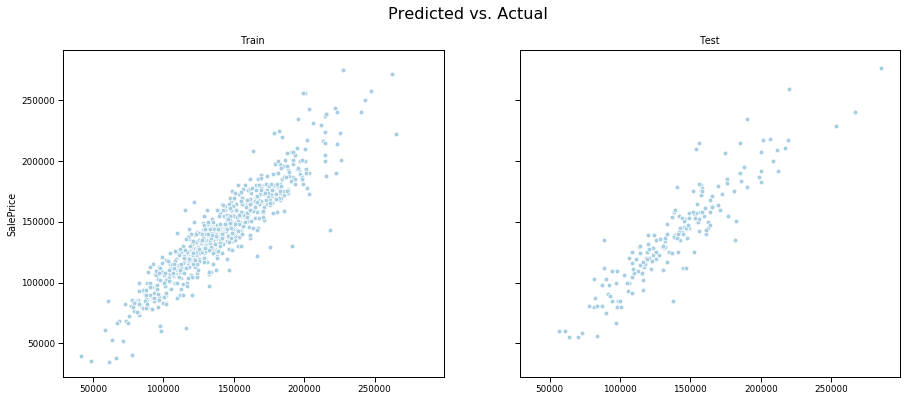

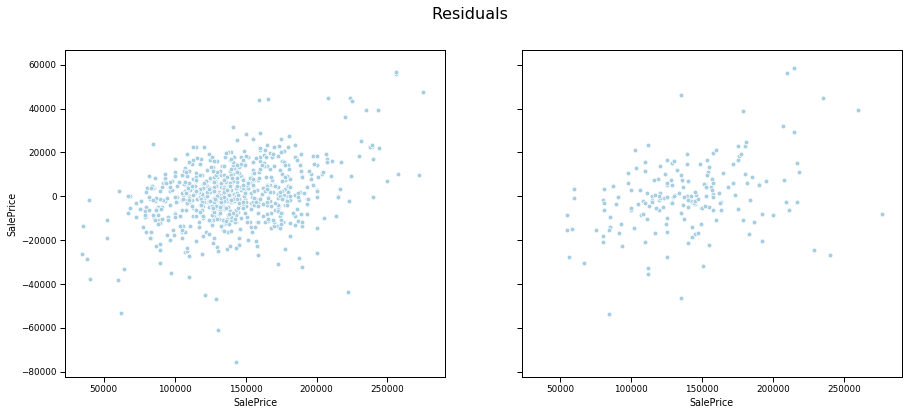

In [1049]:
model_summary(lassolars_high)

## Bayesian Ridge

In [1050]:
br_low = linear_model.BayesianRidge().fit(X_train, y_train)

R-sq: 			0.8874
RMSE (Train): 		0.0943
RMSE (Test): 		0.1218
CV_RMSE (Train): 	0.1175
CV_RMSE (Test): 	0.1393


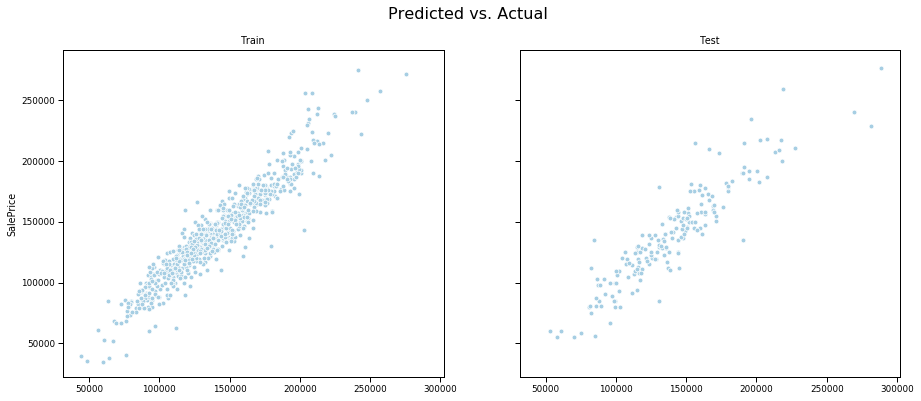

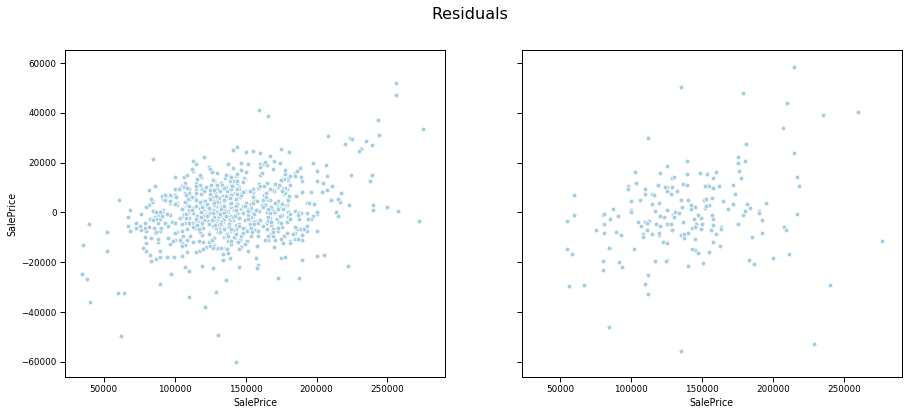

In [1051]:
model_summary(br_low)

### Predictions based on Ridge for cluster: High

In [1055]:
y_hat_high = ridge_high.predict(df_train_high)

In [1062]:
y_hat_c = np.append(y_hat_high,y_hat_low)

In [1063]:
y_actual_c = np.append(df_y_high, df_y_low)

In [1064]:
np.sqrt(mean_squared_error(y_actual_c, y_hat_c))

0.09464326934975249

In [1065]:
y_hat = ridge.predict(df_train)

In [1066]:
np.sqrt(mean_squared_error(y_hat, df_y))

0.0986738011125506

### Evaluate Low + High RMSE

# PCA